#Analysis of Single-Nucleotide Polymorphisms in Human Voltage-Gated Ion Channels

Reincarnation of our original work that was published in Journal of Proteome Research ( DOI: 10.1021/acs.jproteome.9b00121).

##Import libraries

In [ ]:
import requests
import csv
import pandas as pd
import re
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols,glm
from os import sep
from wordcloud import WordCloud, STOPWORDS
#in case of reformatiting the code, comment the next two lines
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Load Data from the FTP Servers of ClinVar and UniProtKB


### Retrieve data about missense SNPs from UniProtKB

In [ ]:
link = 'https://www.uniprot.org/docs/humsavar'
r = requests.get(link)
open('humasavar.txt', 'wb').write(r.content)

#Delete lines
with open('humasavar.txt','r+') as file:
    lines = file.readlines()
    file.seek(0)
    # truncate the file
    file.truncate()

    file.writelines(lines[60:80549])    
file.close()

In [ ]:
#Reformat the file so it can be converted to a pandas DF
with open('humasavar.txt','r+') as file:
    lines = file.readlines()

for i in range(len(lines)):
  lines[i] = re.sub('\s{2,14}', ',', lines[i])
  lines[i] = re.sub('<\/{1}a>|<a \S+\'>|p\.','',lines[i])

with open('humasavar.txt', 'w') as rewrite:
    for line in lines:
        rewrite.write(str(line))

In [ ]:
uniprot_snps = pd.read_csv('humasavar.txt',on_bad_lines='skip',header=None)
uniprot_snps.rename(columns = {0:'GeneName',1:"UniprotAC",2:"VariantID",3:"SNP",4:"ClinicalSignificance",5:"dbSNP_id",6:"Phenotype"},inplace = True)
uniprot_snps.drop(columns = ["VariantID","dbSNP_id"],inplace = True)

#### Filter SNPs related to VGICs

In [ ]:
vgics ={"CACNA1S":"Q13698","CACNA1C":"Q13936","CACNA1D":"Q01668","CACNA1F":"O60840","CACNA1A":"O00555","CACNA1B":"Q00975",
        "CACNA1E":"Q15878","CACNA1G":"O43497","CACNA1H":"O95180","CACNA1I":"Q9P0X4","KCNA1":"Q09470","KCNA2":"P16389","KCNA3":"P22001",
        "KCNA4":"P22459","KCNA5":"P22460","KCNA6":"P17658","KCNA7":"Q96RP8","KCNA10":"Q16322","KCNB1":"Q14721","KCNB2":"Q92953","KCNC1":"P48547",
        "KCNC2":"Q96PR1","KCNC3":"Q14003","KCNC4":"Q03721","KCND1":"Q9NSA2","KCND2":"Q9NZV8","KCND3":"Q9UK17","KCNF1":"Q9H3M0","KCNG1":"Q9UIX4",
        "KCNG2":"Q9UJ96","KCNG3":"Q8TAE7","KCNG4":"Q8TDN1","KCNQ1":"P51787","KCNQ2":"O43526","KCNQ3":"O43525","KCNQ4":"P56696","KCNQ5":"Q9NR82",
        "KCNV1":"Q6PIU1","KCNV2":"Q8TDN2","KCNS1":"Q96KK3","KCNS2":"Q9ULS6","KCNS3":"Q9BQ31","KCNH1":"O95259","KCNH5":"Q8NCM2","KCNH2":"Q12809",
        "KCNH6":"Q9H252","KCNH7":"Q9NS40","KCNH8":"Q96L42","KCNH3":"Q9ULD8","KCNH4":"Q9UQ05","SCN1A":"P35498","SCN2A":"Q99250","SCN3A":"Q9NY46",
        "SCN4A":"P35499","SCN5A":"Q14524","SCN8A":"Q9UQD0","SCN9A":"Q15858","SCN10A":"Q9Y5Y9","SCN11A":"Q9UI33"}

uniprot_snps_vgics = uniprot_snps[uniprot_snps['UniprotAC'].isin(vgics.values())]

uniprot_snps_vgics.reset_index(drop = True, inplace = True)   

#Reform Clinsig
uniprot_snps_vgics.replace('LP/P', 'Pathogenic', inplace=True)
uniprot_snps_vgics.replace('LB/B', 'Polymorphism', inplace=True)
uniprot_snps_vgics.replace('US', 'Unclassified', inplace=True)

uniprot_snps_vgics

,GeneName,UniprotAC,SNP,ClinicalSignificance,Phenotype
0,CACNA1A,O00555,Thr665Met,Pathogenic,Episodic ataxia 2 (EA2) [MIM:108500]
1,CACNA1A,O00555,Ala21Val,Polymorphism,-
2,CACNA1A,O00555,Pro913Ser,Polymorphism,-
3,CACNA1A,O00555,Glu917Asp,Polymorphism,-
4,CACNA1A,O00555,Glu1014Lys,Polymorphism,-
...,...,...,...,...,...
1933,SCN9A,Q15858,Leu1278Val,Polymorphism,-
1934,SCN9A,Q15858,Leu1623Pro,Pathogenic,Paroxysmal extreme pain disorder (PEPD) [MIM:1...
1935,SCN9A,Q15858,Ala1643Glu,Pathogenic,Paroxysmal extreme pain disorder (PEPD) [MIM:1...
1936,SCN9A,Q15858,Ala1643Glu,Pathogenic,Primary erythermalgia (PERYTHM) [MIM:133020]


### Retrieving missense SNPs on human VGICs from ClinVar

In [ ]:
clinvar = 'https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz'
res = requests.get(clinvar)
open('variant_summary.txt', 'wb').write(res.content)
clinvar_snps = pd.read_csv('variant_summary.txt',on_bad_lines='skip',sep='\t', compression='gzip')

canonical = ['NM_001127222','NM_018896','NM_004519','NM_172107','NM_005183','NM_021098','NM_172362','NM_004974','NM_002232','NM_002234','NM_001165963','NM_000334',
             'NM_004976','NM_000218','NM_004700','NM_000718','NM_001128840','NM_000217','NM_000238','NM_000069','NM_199460','NM_004977',
            'NM_198056','NM_004975','NM_001205293','NM_139318','NM_133497','NM_001040142','NM_002236','NM_019842','NM_033272','XM_017004660',
             'NM_012281','NM_021096','NM_014139','NM_004980','NM_014191','NM_006514','NM_001365536','NM_002235','NM_002233','NM_004978',
             'NM_005549','NM_014379','NM_133329','NM_172347','NM_004770','NM_001322799','NM_002251','NM_144633','NM_139137','NM_031886',
             'NM_001282428','NM_002252','NM_030779','NM_004979','NM_002237','NM_012283','NM_001314030','NM_012284','NM_020697','NM_012285']

#### Preprocessing of ClinVar SNPs:
1. filter SNPs of the latest version of human genome (GrCH38)
2. keep only columns with info about the Gene Name, the SNP, its clinical significance and association with disease if any
3. filter vgics-related SNPs
4. drop duplicates
5. keep only the canonical isoform of each protein
6. rename Clinical Significance values using the following approach: <br>
      a) risk factor, Likely benign, Benign & drug response will be set as Polymorphism <br>
      b)Conflicting interpretations of pathogenicity, no interpretation for the single variant, not provided, Conflicting interpretations of pathogenicity; risk factor, association & Uncertain significance will be set as Unclassified <br>
      c)Pathogenic/Likely pathogenic and Likely pathogenic will be set as Pathogenic

In [ ]:
SNPs = clinvar_snps.copy()
#1. filter SNPs of the latest version of human genome (GrCH38) &
#2. keep only columns with info about the Gene Name, the SNP, its clinical significance and association with disease if any

SNPs = SNPs[(SNPs.Type == 'single nucleotide variant') & (SNPs.Assembly == 'GRCh38')]
SNPs.drop(SNPs.iloc[:, 14:], inplace=True, axis=1)
SNPs.drop(SNPs.iloc[:, 7:13], inplace=True, axis=1)
SNPs.drop(SNPs.columns[[0,1,3,5]],axis = 1, inplace=True)
SNPs.rename(columns = {'GeneSymbol':'GeneName','PhenotypeList':'Phenotype'},inplace = True)

#3. filter vgics-related SNPs & 4. drop duplicates
clinvar_snps_vgics = SNPs[SNPs['GeneName'].isin(vgics.keys())]
clinvar_snps_vgics.drop_duplicates(subset=['Name','GeneName','ClinicalSignificance'],inplace = True)
clinvar_snps_vgics = clinvar_snps_vgics[clinvar_snps_vgics ['Name'].str.contains("Ter|=")==False]

#keep RefSeq ID (we need that to filter the canonical isoform) and SNP in different columns
new_cols = clinvar_snps_vgics['Name'].str.extract('(?P<RefSeq>NM_\S+)\.\d\(\S+>\w\s\(p\.(?P<SNP>[\s\S]+)\)', 
                                     expand=True)
clinvar_snps_vgics = pd.concat([clinvar_snps_vgics, new_cols], axis=1)
clinvar_snps_vgics.drop(clinvar_snps_vgics.columns[0],axis = 1, inplace = True)
clinvar_snps_vgics["UniprotAC"] = clinvar_snps_vgics["GeneName"].map(vgics)
clinvar_snps_vgics = clinvar_snps_vgics[['GeneName','UniprotAC','RefSeq','SNP','ClinicalSignificance','Phenotype']]

#5. keep only the canonical isoform of each protein
clinvar_snps_vgics = clinvar_snps_vgics[clinvar_snps_vgics['RefSeq'].isin(canonical)]
clinvar_snps_vgics.drop(columns = ['RefSeq'], inplace = True)
clinvar_snps_vgics.reset_index(drop = True, inplace = True)

#6. rename Clinical Significance values 
replace_values = {"risk factor": "Polymorphism","Likely benign":"Polymorphism","Benign/Likely benign":"Polymorphism","Benign":"Polymorphism",'drug response':"Polymorphism",
                  'Conflicting interpretations of pathogenicity':"Unclassified",'no interpretation for the single variant':"Unclassified",
                  'not provided':"Unclassified",'Conflicting interpretations of pathogenicity; risk factor':"Unclassified",'association':"Unclassified",
                  'Uncertain significance':"Unclassified",'Pathogenic/Likely pathogenic':'Pathogenic','Likely pathogenic':'Pathogenic',
                  'Pathogenic':'Pathogenic'}
clinvar_snps_vgics.replace({'ClinicalSignificance':replace_values},inplace = True)

clinvar_snps_vgics

,GeneName,UniprotAC,SNP,ClinicalSignificance,Phenotype
0,CACNA1H,O95180,Phe161Leu,Polymorphism,"Epilepsy, childhood absence, susceptibility to, 6"
1,CACNA1H,O95180,Glu282Lys,Unclassified,"Epilepsy, childhood absence, susceptibility to..."
2,CACNA1H,O95180,Val831Met,Unclassified,"Epilepsy, childhood absence, susceptibility to..."
3,CACNA1H,O95180,Gly773Asp,Polymorphism,"Hyperaldosteronism, familial, type IV;Idiopath..."
4,CACNA1H,O95180,Pro618Leu,Unclassified,"Epilepsy, idiopathic generalized 6|not provide..."
...,...,...,...,...,...
13087,SCN4A,P35499,Gly1762Glu,Unclassified,Familial hyperkalemic periodic paralysis
13088,CACNA1G,O43497,Ser2123Tyr,Unclassified,Spinocerebellar ataxia type 42
13089,CACNA1A,O00555,Asp302His,Unclassified,not provided
13090,SCN10A,Q9Y5Y9,Arg817Gln,Polymorphism,not provided


## Merge Datasets to construct the Final Dataset of Missense SNPs for human VGICs

During the merging process SNPs presented in both datasets intoduced only once keeping the clinical significance from ClinVardb 

In [ ]:
final_df_snps = pd.concat([clinvar_snps_vgics, uniprot_snps_vgics]).drop_duplicates(['GeneName','UniprotAC','SNP'],keep= 'first')

splitted_cols = final_df_snps['SNP'].str.extract('(?P<normaa>\w{3})(?P<Position>\d+)(?P<snp>\w{3})', 
                                     expand=True)
final_df_snps = pd.concat([final_df_snps, splitted_cols], axis=1)
final_df_snps.drop('SNP',axis = 1, inplace = True)
final_df_snps.reset_index(drop = True, inplace= True)

final_df_snps = final_df_snps[['GeneName','UniprotAC','normaa','Position','snp','ClinicalSignificance','Phenotype']]
final_df_snps.rename(columns = {'snp':'SNP'},inplace = True)

final_df_snps

,GeneName,UniprotAC,normaa,Position,SNP,ClinicalSignificance,Phenotype
0,CACNA1H,O95180,Phe,161,Leu,Polymorphism,"Epilepsy, childhood absence, susceptibility to, 6"
1,CACNA1H,O95180,Glu,282,Lys,Unclassified,"Epilepsy, childhood absence, susceptibility to..."
2,CACNA1H,O95180,Val,831,Met,Unclassified,"Epilepsy, childhood absence, susceptibility to..."
3,CACNA1H,O95180,Gly,773,Asp,Polymorphism,"Hyperaldosteronism, familial, type IV;Idiopath..."
4,CACNA1H,O95180,Pro,618,Leu,Unclassified,"Epilepsy, idiopathic generalized 6|not provide..."
...,...,...,...,...,...,...,...
13749,SCN8A,Q9UQD0,Val,1598,Ala,Pathogenic,Developmental and epileptic encephalopathy 13 ...
13750,SCN9A,Q15858,Met,932,Leu,Polymorphism,-
13751,SCN9A,Q15858,Met,1638,Lys,Pathogenic,Paroxysmal extreme pain disorder (PEPD) [MIM:1...
13752,SCN9A,Q15858,Glu,1171,Gln,Unclassified,-


## Introducing tobological features for each SNP

###Retrieve topologigal data for each VGIC from UniProtKB/SwissProt

In [ ]:
temp = []

for name in vgics.values():
  url = f'https://www.uniprot.org/uniprot/?query=reviewed:yes+AND+organism:9606+AND+id:{name}&columns=id,genes(PREFERRED),feature(TRANSMEMBRANE),length&format=tab'

  urlData = requests.get(url).content
  temp.append(urlData.decode('utf-8'))

joinedTOPDOM =''.join(temp)

data = io.StringIO(joinedTOPDOM)
rawData = pd.read_csv(data, sep="\t")

rawData = rawData[rawData.Entry != 'Entry'] # drop rows with same content as the headers
rawData.reset_index(inplace=True)
rawData.columns

Index(['index', 'Entry', 'Gene names  (primary )', 'Transmembrane', 'Length'], dtype='object')

###Construct a conclusive map with topological feature for each protein (Walkthrough):
1. Step 1: At first, using pattern matching we extract the length (start & end) and the name of each transmembrane segment of each protein
2. Step 2: Since there is not organised information about the loops and terminals for all proteins, we need to generate the length of the rest topological domains (N- & C- terminal, intra- & extra- cellular loops and pore loop). 
3. Construct a conclusive map with info about the topological features of each protein

In [ ]:
#Re-formating info about transmembrane segments

allTopology = {}
proteinlens = {}

#Step 1
for index, row in rawData.iterrows(): #row['Entry']
  listOFtransmem = []
  topdom = []
  transmem = row['Transmembrane']

  transmem = re.sub(r"\s/evidence=\"(ECO:\S*\s*)*;*|TRANSMEM\s|\s/note=\"Helical;|Name\=(Segment)*|\sof\srepeat\s\w+|\";|Voltage-sensor;", "", transmem)#/evidence=\"(ECO:\S*\s*)*|TRANSMEM\s|/note=|;\s
  transmem = re.sub(r";\s", " ", transmem)
  transmem = re.sub(r"\.\.", " ", transmem)
  draft = re.findall("\S+\s\S+\s+\S+", transmem)
  listOFtransmem = [element.split(' ',2) for element in draft]


  for element in listOFtransmem:
    if not element[1].isdigit():
      tmp = element[-1]
      element[-1] = element[1]
      element[1] = tmp
    element[0] = int(element[0])
    element[1] = int(element[1])
    element[2] = element[2].strip()
    element[2] = element[2].strip('"')

#Step 2
  length = int(rawData.Length[index])
  
  oddseg = []
  evenseg = []
  topdom = []
  #split transmembrane segments in odd & even numbers to set up with more ease the loops
  for element in listOFtransmem:
    if "S1" in element[2] or "S3" in element[2] or "S5" in element[2]:
      oddseg.append(element)
    else:
      evenseg.append(element)

  for i in range(len(oddseg)):
    #set up N- & C- terminal & the first loop of each protein
    if i == 0:
      topdom.append([1,oddseg[i][0]-1,'N-terminal'])
      topdom.append([oddseg[i][1]+1,evenseg[i+1][0]-1,'Extracellular loop'])

    elif i == len(oddseg) -1:
      topdom.append([evenseg[i][1]+1,length,'C-terminal'])

    #set up pore loop and the previous loop for each protein
    if 'S5' in oddseg[i][2]:
      pore_start = oddseg[i][1] + 1
      pore_end = evenseg[i][0] - 1
      loop_start = evenseg[i-1][1] + 1
      loop_end = oddseg[i][0] - 1

      topdom.append([pore_start,pore_end,'Pore loop'])
      topdom.append([loop_start,loop_end,'Intracellular loop'])

    #set the rest of the loops
    elif ('S1' in oddseg[i][2] or 'S3' in oddseg[i][2]) and i != 0:
      eloop_start = oddseg[i][1] + 1
      eloop_end = evenseg[i][0] - 1
      iloop_start = evenseg[i-1][1] + 1
      iloop_end = oddseg[i][0] - 1

      topdom.append([iloop_start,iloop_end,'Intracellular loop'])
      topdom.append([eloop_start,eloop_end,'Extracellular loop'])
#Step 3
  topology = listOFtransmem+topdom #the topological map of each protein
  allTopology[row['Entry']] = topology #organize all topologies in a dictionary
  proteinlens[row['Gene names  (primary )']] = length


###Map all SNPs to the topological domain they belong to

In [ ]:
final_df_snps['Topological domain'] = ''
final_df_snps['Segment']=''
final_df_snps['Segment length'] = 0
final_df_snps['counter'] = 0
for index, row in final_df_snps.iterrows():
  name = final_df_snps['UniprotAC'][index]
  position = final_df_snps['Position'][index]
  for element in allTopology[name]:
    if element[0] <= int(position) <= element[1]:
      final_df_snps['Topological domain'][index] = element[2]
      final_df_snps['Segment'][index] = f'{element[0]}-{element[1]}'
      final_df_snps['Segment length'][index] = element[1]-element[0] + 1
      final_df_snps['counter'][index] = 1

#Rearrange columns
final_df_snps=final_df_snps[['GeneName','UniprotAC','normaa','Position','SNP','Segment','Segment length','Topological domain','ClinicalSignificance','Phenotype','counter']]

In [ ]:
final_df_snps.to_csv("final_dataset.tsv",sep="\t",index = False)
w = csv.writer(open("proteinlens.csv", "w"))

# loop over dictionary keys and values
for key, val in proteinlens.items():

    # write every key and value to file
    w.writerow([key, val])
    

##Descripitive analysis of missense SNPs

Note 1: This section can be executed seperately using the final output from the previous steps: final_dataset.tsv

Note 2: Unclassified SNPs are not part of this analysis (only the total SNPs per topological domain is presented)


### Part I: Raw Counts per Topological Domain

We distinguish the following topological domains:
1. N-terminal
2. Voltage Sensor Domain (VSD, consists of segments S1 - S4)
3. S5
4. Pore loop
5. S6
6. Etracellular loops
7. Intracellular loops
8. C-terminal

In [ ]:
# To run this section separately uncomment the following line
final_df_snps = pd.read_csv("final_dataset.tsv",sep="\t")
final_df_raw = final_df_snps.copy()
#final_df_raw = final_df_raw[final_df_raw['ClinicalSignificance'] != 'Unclassified'] #drop unclassified
final_df_raw.reset_index(drop=True,inplace = True)
final_df_raw["Topological domain"].replace({"S1": "VSD", "S2": "VSD","S3": "VSD","S4": "VSD"}, inplace=True) #Mark S1 - S4 = VSD

RawCounts = final_df_raw.groupby(by=["Topological domain","ClinicalSignificance"], dropna=False).size() #count SNPs per topological domain
RawCounts = pd.DataFrame(RawCounts,columns=['Total SNPs'])
RawCounts.reset_index(level='ClinicalSignificance',inplace = True)
RawCounts = RawCounts.pivot_table('Total SNPs','Topological domain','ClinicalSignificance')
RawCounts = RawCounts.loc[['N-terminal','VSD','S5','Pore loop','S6','Extracellular loop','Intracellular loop','C-terminal']]
RawCounts.loc['Total']= RawCounts.sum()
RawCounts

ClinicalSignificance,Pathogenic,Polymorphism,Unclassified
Topological domain,,,
N-terminal,106,86,1242
VSD,357,49,1051
S5,178,8,303
Pore loop,482,72,1301
S6,193,19,394
Extracellular loop,130,52,718
Intracellular loop,406,295,2691
C-terminal,251,390,2980
Total,2103,971,10680


### Part II: Plot normalized frequencies of Pathological SNPs and Polymorphisms per topological domain

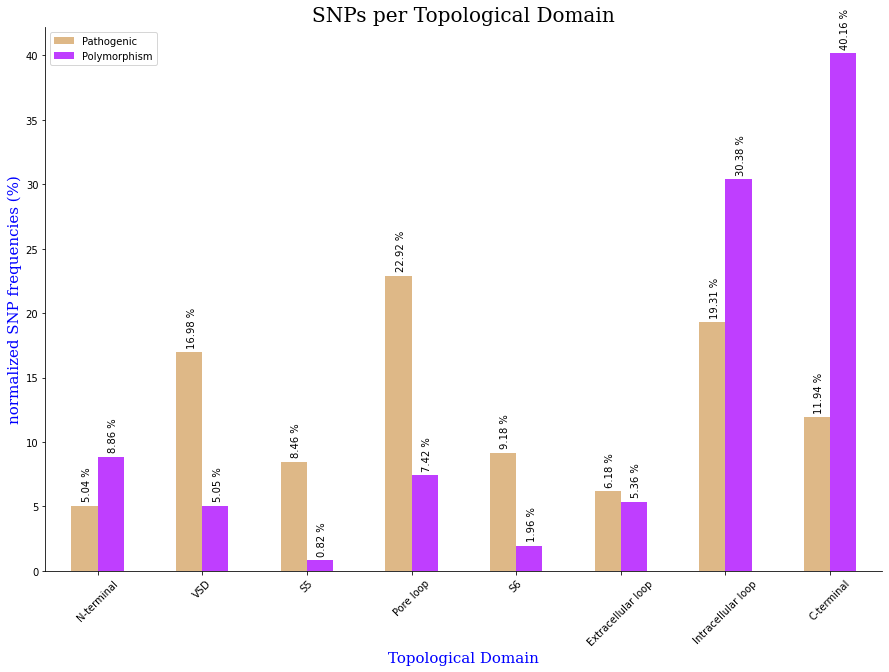

In [ ]:
#Plotting
RawCounts_copy = RawCounts.copy() 
RawCounts_copy.drop('Unclassified',axis = 1,inplace = True)#drop uncalssified
RawCounts_copy.drop(RawCounts_copy.tail(1).index,inplace=True)
RawCounts_copy['Pathogenic'] = (RawCounts_copy['Pathogenic']/RawCounts_copy['Pathogenic'].sum())*100
RawCounts_copy['Polymorphism'] = (RawCounts_copy['Polymorphism']/RawCounts_copy['Polymorphism'].sum())*100


fig, ax = plt.subplots(figsize=(15,10))
RawCounts_copy.plot.bar(rot = 45, color = ['#DEB887','#BF3EFF'], ax = ax)
plt.title("SNPs per Topological Domain",fontdict = {'family':'serif','color':'black','size':20})
plt.xlabel("Topological Domain",fontdict = {'family':'serif','color':'blue','size':15})
plt.ylabel("normalized SNP frequencies (%)",fontdict = {'family':'serif','color':'blue','size':15})

#add bar labels
for i, v in enumerate(RawCounts_copy['Pathogenic']):
    ax.text(i-0.15,v + 0.5, f'{round(v,2)} %',rotation = 90)
    poly_v =round(RawCounts_copy['Polymorphism'][i], 2)
    ax.text(i + 0.1,poly_v+ 0.5,f'{poly_v} %',rotation = 90)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Part III: Normalized Counts of SNPs per Topologocical Domain & Protein according to Topological domain's length

Counts of SNPs are normalized in scale 0-100 according to the length of the topological domain they belong to. In that sense, if there are 5 in a segment of 20 residues, after normalization it will become 25/100)

In [ ]:
final_df_norm = final_df_raw.copy()
final_df_norm = final_df_norm[final_df_norm['ClinicalSignificance'] != 'Unclassified'] #drop unclassified
#normalize SNPs occurances according to topological domain's length
final_df_norm['counter'] = (final_df_norm['counter']/final_df_norm['Segment length'])*100

NormCounts = pd.DataFrame(final_df_norm.groupby(['GeneName','Topological domain','ClinicalSignificance']).counter.sum())
NormCounts_pivot = NormCounts.pivot_table('counter',['GeneName','ClinicalSignificance'],'Topological domain')
NormCounts_pivot.fillna(0,inplace= True)
NormCounts_pivot = NormCounts_pivot[['N-terminal','VSD','S5','Pore loop','S6','Extracellular loop','Intracellular loop','C-terminal']]
NormCounts_pivot

Topological domain             N-terminal         VSD         S5  Pore loop  \
GeneName ClinicalSignificance                                                 
CACNA1A  Pathogenic              0.000000   94.210526  40.000000  19.434504   
         Polymorphism            2.040816    5.263158   0.000000   3.687739   
CACNA1B  Polymorphism            3.333333    8.761905   0.000000   1.612903   
CACNA1C  Pathogenic              0.000000    0.000000   0.000000   0.000000   
         Polymorphism            1.612903    0.000000   0.000000   1.111111   
...                                   ...         ...        ...        ...   
SCN5A    Pathogenic              4.580153  117.005504  21.374269  32.264403   
         Polymorphism            1.526718   15.789474   0.000000   3.418803   
SCN8A    Pathogenic              0.000000   44.840041  15.526316   0.000000   
SCN9A    Pathogenic              0.000000   22.583419  21.052632   2.686203   
         Polymorphism            0.793651    5.000000   0.000000   5.174405   

Topological domain                    S6  Extracellular loop  \
GeneName ClinicalSignificance                                  
CACNA1A  Pathogenic            44.000000            4.109589   
         Polymorphism           0.000000            0.000000   
CACNA1B  Polymorphism           0.000000            2.739726   
CACNA1C  Pathogenic             4.000000            0.000000   
         Polymorphism           4.761905            0.000000   
...                                  ...                 ...   
SCN5A    Pathogenic            31.874647           84.527972   
         Polymorphism           4.761905            0.000000   
SCN8A    Pathogenic             4.545455           18.181818   
SCN9A    Pathogenic             4.761905            0.000000   
         Polymorphism           4.545455           16.666667   

Topological domain             Intracellular loop  C-terminal  
GeneName ClinicalSignificance                                  
CACNA1A  Pathogenic                     61.453539    0.571429  
         Polymorphism                    5.979437    2.000000  
CACNA1B  Polymorphism                    2.496915    1.582278  
CACNA1C  Pathogenic                     18.371863    0.143472  
         Polymorphism                    1.290323    1.578192  
...                                           ...         ...  
SCN5A    Pathogenic                    101.482199    8.163265  
         Polymorphism                   11.928106    3.265306  
SCN8A    Pathogenic                     10.921924    2.325581  
SCN9A    Pathogenic                     59.348261    0.436681  
         Polymorphism                   26.265047    0.873362  

[81 rows x 8 columns]

### Part IV: Perform 2-way ANOVA with replication to examine the connection between an SNP’s pathogenicity status and its appearance in transmembrane regions

If resulting P-value is $\le$ 0.05, the under-study parameter is considered statistically significant.
In this case we investigate the significance of:
</br> a. the appearence of SNPs in transmembrane (TM) segments
</br> b. the difference between polymorphisms & pathogenic SNPs and 
</br> c. the combined association of the two parameters (meaning the presense of pathogenic SNPs in TM segments or not).

In [ ]:
#Prepare data for ANOVA
ANOVAdata = NormCounts.copy()
ANOVAdata.reset_index(inplace=True)
ANOVAdata.rename(columns = {'Topological domain':'TopologicalDomain'},inplace=True)
ANOVAdata["TopologicalDomain"].replace({"VSD": "TM","S5": "TM","S6": "TM"}, inplace=True) 
ANOVAdata["TopologicalDomain"].replace({"N-terminal": "NOTM", "C-terminal": "NOTM","Pore loop":"NOTM", "Extracellular loop":"NOTM","Intracellular loop": "NOTM"}, inplace=True) 

#apply 2-way ANOVA with replication
model = ols('counter ~ TopologicalDomain + ClinicalSignificance + TopologicalDomain:ClinicalSignificance', data=ANOVAdata).fit()
result = sm.stats.anova_lm(model, typ=2) #anova result in Df
result.rename(columns={'PR(>F)':'Pvalue'},inplace = True)
result


,sum_sq,df,F,Pvalue
TopologicalDomain,10851.746030,1.0,3.778409,5.275504e-02
ClinicalSignificance,82157.535325,1.0,28.605978,1.646349e-07
TopologicalDomain:ClinicalSignificance,3779.543322,1.0,1.315978,2.521337e-01
Residual,962133.666672,335.0,NaN,NaN


### Part V: Apply  Binomial Generalized Linear Model Regression(GLM) to investigate the distribution of polymorphisms and pathogenic mutations in different topological regions of biological significance & distinquish the ones that statistically significant

**Note 1:** To apply binomial GLM the raw format of the final dataset is used as the initial input, since normalization will introduce extra bias</br>
</br>
**Note 2:** Topological domains are grouped as follows, for statistical purposes:</br>VSD</br>Pore loop (PL)</br>Intracellular loop (IL)</br>Extracellular loop (EL) and</br>Other(N-terminal, C-terminal, S5 and S6 segments)
</br></br>
**Note 3:** If resulting p-value $\le$ 0.05 and parameter z (estimate) $\gt$ 0, SNPs are more likely to be pathogenic in these topological domains, while if p-value $\le$ 0.05 and parameter z (estimate) $\lt$ 0, SNPs are more likely to be polymorphisms in there regions.


In [ ]:
#Prepare data for Binomial GLM
prep_data = final_df_raw.copy()
prep_data = prep_data[prep_data['ClinicalSignificance'] != 'Unclassified']
prep_data["Topological domain"].replace({"N-terminal": "Other","S5":"Other" ,"S6":"Other","C-terminal": "Other",
                                         "Extracellular loop":"EL","Pore loop":"PL","Intracellular loop":"IL"}, inplace=True)
prep_data = prep_data.groupby(['GeneName','ClinicalSignificance',
                   'Topological domain']).size().reset_index()
prep_data.rename({0:"Total SNPs"},axis = 1, inplace = True)
prep_data = prep_data.pivot_table('Total SNPs',['GeneName','ClinicalSignificance'],'Topological domain').reset_index(level='ClinicalSignificance')

prep_data.fillna(0,inplace=True)
prep_data["ClinicalSignificance"].replace({"Pathogenic": 1, "Polymorphism": 0}, inplace=True)


#Apply binomial GLM
np.seterr(divide='ignore', invalid='ignore') #ignore division by zero
mod1 = glm(formula="ClinicalSignificance ~ VSD+PL+Other+EL+IL", data=prep_data, family=sm.families.Binomial()).fit()
print(mod1.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     ClinicalSignificance   No. Observations:                   81
Model:                              GLM   Df Residuals:                       75
Model Family:                  Binomial   Df Model:                            5
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                    nan
Date:                  Sun, 01 May 2022   Deviance:                          nan
Time:                          05:58:05   Pearson chi2:                     67.2
No. Iterations:                     100                                         
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3703      0.388

### Part VI: Analyzing the Distribution of Amino Acid Substitutions for Polymorphisms and Pathogenic Mutations in VGICs.

#### Distribution of pathogenic SNPs and polymorphisms according to biophysical attributes of amino aicd residues
<font color='breen'>Non-polar</font>: Ala, Val, Leu, Ile, Pro, Gly, Phe </br>
<font color='blue'>Charged</font>: Lys, Arg, Asp, Glu </br>
<font color='bpurple'>Polar</font>: Gln, Asn, Ser, Tyr, Thr, Cys, His, Met, Trp

In [ ]:
aa_groups = {'Ala':'nonpolar','Val':'nonpolar','Leu':'nonpolar','Ile':'nonpolar','Pro':'nonpolar','Gly':'nonpolar','Phe':'nonpolar',
             'Asn':'polar','Ser':'polar','Tyr':'polar','Trp':'polar','Cys':'polar','Met':'polar','Thr':'polar','His':'polar','Gln':'polar',
             'Lys':'charged','Arg':'charged','Glu':'charged','Asp':'charged'}

biophys_df_snps = final_df_raw.copy()
biophys_df_snps['SNP']=biophys_df_snps['SNP'].map(aa_groups)
biophys_df_snps['normaa']=biophys_df_snps['normaa'].map(aa_groups)
aachanges_normcounts = biophys_df_snps.groupby(['normaa','SNP','Topological domain','ClinicalSignificance']).counter.sum().reset_index()
aachanges_pivot = aachanges_normcounts.pivot_table('counter',['normaa','SNP'],'ClinicalSignificance')
aachanges_pivot

ClinicalSignificance  Pathogenic  Polymorphism  Unclassified
normaa   SNP                                                
charged  charged       11.285714      9.833333     98.571429
         nonpolar      21.833333     11.666667     79.428571
         polar         43.000000     31.333333    252.571429
nonpolar charged       26.375000      8.500000     80.750000
         nonpolar      57.875000     28.875000    294.875000
         polar         41.250000     21.750000    213.500000
polar    charged       20.625000      7.666667     74.250000
         nonpolar      28.750000      9.500000    130.750000
         polar         29.500000     13.875000    164.125000

#### Apply Binomial GLM to investigate with amino acid substitions are more likely to generate a pathogenic status

Amino acid substitutions with p-value $\le$ 0.05 are considered statistically significant

In [ ]:
#Prepare data for logit regression
biophys_df_snps['aachange']= biophys_df_snps[['normaa', 'SNP']].agg('_'.join, axis=1)[biophys_df_snps['ClinicalSignificance']!='Unclassified']
aachanges = biophys_df_snps.groupby(['GeneName','ClinicalSignificance','aachange']).counter.sum().reset_index()
aachanges = aachanges.pivot_table('counter',['GeneName','ClinicalSignificance'],'aachange')
aachanges.reset_index('ClinicalSignificance',inplace = True)
aachanges["ClinicalSignificance"].replace({"Pathogenic": 1, "Polymorphism": 0}, inplace=True)
aachanges.fillna(0,inplace = True)

#Apply binomial GLM
np.seterr(divide='ignore', invalid='ignore') #ignore division by zero

aachanges_mdl = glm(formula="ClinicalSignificance ~ charged_charged + charged_nonpolar + charged_polar + nonpolar_charged\
+nonpolar_nonpolar + nonpolar_polar + polar_charged + polar_nonpolar + polar_polar", data=aachanges, family=sm.families.Binomial()).fit()

print(aachanges_mdl.summary())


                  Generalized Linear Model Regression Results                   
Dep. Variable:     ClinicalSignificance   No. Observations:                   81
Model:                              GLM   Df Residuals:                       71
Model Family:                  Binomial   Df Model:                            9
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                    nan
Date:                  Sun, 01 May 2022   Deviance:                          nan
Time:                          05:58:05   Pearson chi2:                     64.4
No. Iterations:                     100                                         
Covariance Type:              nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         

#### Distribution (%) of aa-changes resulting to Pathogenic SNPs

Note 1: To <font color = 'breen'> enrich </font>our dataset and <font color = 'magenta'>examine the statistical significance </font>of the amino acid substitutions, we performed random sampling with replacement (<font color = 'cyan'>bootstrap</font>). In the following section the application to the subset of pathogenic SNPs is presneted.

In [ ]:
#Perform bootstrap
sample = final_df_norm[['normaa', 'SNP']].agg('_'.join, axis=1)[final_df_norm['ClinicalSignificance']=='Pathogenic']
sample.reset_index(drop = True)
bootstrapped_samples = []
for _ in range(1000):
    x = np.random.choice(sample, size=len(sample), replace=True)
    bootstrapped_samples.append(x)
bootstrapped_samples.append(list(sample))

bootstrapped_list = [x.split('_') for boot_list in bootstrapped_samples for x in boot_list ]


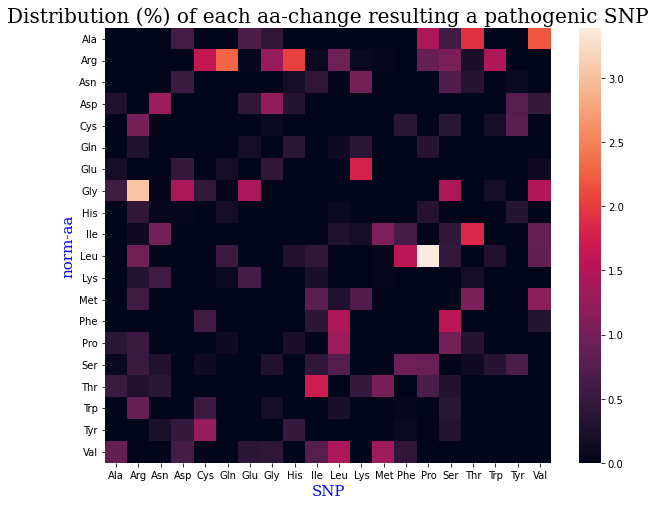

In [ ]:
#% occuarance of each aa-substitution (viz in heatmaps)
total_snps = len(bootstrapped_list)
bootstrapped_df = pd.DataFrame(bootstrapped_list,columns=['normaa','SNP'])
bootstrapped_df = bootstrapped_df.groupby(['normaa','SNP']).size().reset_index(level='SNP')
bootstrapped_df.rename({0:"Total SNPs"},axis = 1,inplace = True)
bootstrapped_df = bootstrapped_df.pivot_table("Total SNPs",'normaa','SNP')
bootstrapped_df.fillna(0,inplace = True)
bootstrapped_df = (bootstrapped_df/total_snps)*100
bootstrapped_df

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(bootstrapped_df, cmap = 'rocket')
plt.title('Distribution (%) of each aa-change resulting a pathogenic SNP',fontdict = {'family':'serif','color':'black','size':20})
plt.xlabel("SNP",fontdict = {'family':'serif','color':'blue','size':15})
plt.ylabel("norm-aa",fontdict = {'family':'serif','color':'blue','size':15})
plt.yticks(rotation = 0)
plt.show()

## Association of human VGICs with Diseases - Record of Channelopathies

**Note 1**:<font color = 'breen'> Categorization of diseases was conducted according to the orginal work </font></br>

**Note 2:**<font color = 'cyan'> Phenotypes were grouped to one of the following 'Disease types' according to specific keywords:</font>
1. ND: Neuron Disease
2. HMD: Heart Muscle Disease
3. MD: Muscle Disease
4. Other: in the case that no keyword matched the phenotype reference</br>
**Note 3:**
Diseases were manually annotated according to specific keywords <font color = 'red'> (this step needs more automation or update if new data become available) </font>.

In [ ]:
diseases_df = final_df_snps.copy()

#Form the Channelopathies subset - Filter out dublicate entries
diseases_df = diseases_df[['GeneName','Phenotype']][diseases_df['Phenotype'] != '-'].reset_index(drop=True)
diseases_df["Phenotype"]=diseases_df["Phenotype"].str.split("\||;") #split records with multiple phenotypes
diseases_df = diseases_df.explode("Phenotype").reset_index(drop=True)
diseases_df.drop_duplicates(['GeneName','Phenotype'],keep='first',inplace = True,ignore_index = True)
diseases_df['VGIC Family'] = ''

#Find meaningful phrases using Wordcloud
text = " ".join(disease.lower() for disease in diseases_df.Phenotype)

wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)

# create a dictionary of word frequencies
text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#categoriaze diseases according to speciific keywords
disease_types = {}

for key, value in word_freq.items():
  if re.match('.*infant.*|.*encepha.*|sotos.*|lennox.*|strabismus|dravet.*|.*nerv.*|joubert.*|parkinson.*|speech|west.*|.*epile|neonatal|temple.*|.*tremor.*|.*motor.*|hemiplegic.*|.*spastic.*|neur.*|deafness|inborn|retinal|ataxia|.*cereb|.*seizure|intellectual|cone|brain|developmental|.*autis.*|hearing|.*centrotemporal.*', key):
    disease_types[key] = 'ND'
  elif re.match('.*qt.*|br.*g.*|.*fibrillation.*|tachycardia|jervell|sinus|.*cardi.*|vascular.*|angiopathy|.*eryth.*|atrial|heart|hypertension', key):
    disease_types[key] ='HMD'
  elif re.match('.*toni.*|.*my.*|.*spastic.*|.*hyperthermia.*|kinesigenic|.*musc.*|.*hemorrhage.*|.*ventricular.*|.*periodic paralysis.*|pain|move', key):
    disease_types[key] ='MD'

#Drop rows with nosense or not provided Phenotype information
for index,row in diseases_df.iterrows():
  if diseases_df['Phenotype'][index].strip().isnumeric() or re.match('type |not provided|^mild$|hereditary essential|atypical|^recessive$|^digenic$|^acquired$|not specified|susceptibility to|^familial$|^severe$|.*walking$|.*conditions$|.*cases$|early-onset|^\d\w$',diseases_df['Phenotype'][index].strip()):
    diseases_df.drop(index,axis=0,inplace = True)


#Introduce the disease type coding to each record.
diseases_df['Disease type'] = ''
for index,row in diseases_df.iterrows():
  for key,value in disease_types.items():
    tmp = re.sub('\-|\s*and\s',' ',diseases_df['Phenotype'][index].lower())
    if key.lower() in tmp:
      diseases_df['Disease type'][index] = value

diseases_df.replace('', 'Other', inplace = True) #characterize phenotypes that did not match to any of the 3 types as 'Other'

diseases_df.reset_index(drop=True)
diseases_df

,GeneName,Phenotype,VGIC Family,Disease type
0,CACNA1H,"Epilepsy, childhood absence, susceptibility to, 6",Other,ND
1,CACNA1H,Idiopathic generalized epilepsy,Other,ND
2,CACNA1H,"Hyperaldosteronism, familial, type IV",Other,Other
3,CACNA1H,"Epilepsy, idiopathic generalized 6",Other,ND
5,KCNV2,Cone dystrophy with supernormal rod response,Other,ND
...,...,...,...,...
542,SCN5A,Atrial standstill 1 (ATRST1) [MIM:108770],Other,HMD
543,SCN5A,Sudden infant death syndrome (SIDS) [MIM:272120],Other,ND
544,SCN8A,Developmental and epileptic encephalopathy 13 ...,Other,ND
545,SCN9A,Paroxysmal extreme pain disorder (PEPD) [MIM:1...,Other,MD


In [ ]:
#Disease distribution per VGIC family
for index,row in diseases_df.iterrows():
  if 'CACN' in diseases_df['GeneName'][index]:
    diseases_df['VGIC Family'][index] = 'Cavs'
  if 'KCN' in diseases_df['GeneName'][index]:
    diseases_df['VGIC Family'][index] = 'Kvs'
  if 'SCN' in diseases_df['GeneName'][index]:
    diseases_df['VGIC Family'][index] = 'Navs'
  
diseases_df.drop_duplicates(['VGIC Family','Phenotype'],inplace = True)
diseases_pivot = diseases_df.groupby(['VGIC Family','Disease type']).size().reset_index('Disease type')
diseases_pivot.rename({0:'Freq'},axis = 1,inplace = True)
diseases_pivot.pivot_table('Freq','VGIC Family','Disease type')

Disease type,HMD,MD,ND,Other
VGIC Family,,,,
Cavs,4,14,49,31
Kvs,36,16,54,27
Navs,11,38,65,23
